## Project Report

### Introduction

Cardiovascular disease (also known as heart disease) is a type of disease that affects the heart or blood vessels. This is one of the leading causes of death in the world, whereby patients suffering from this disease have compromised circulatory systems due to several factors including age, sex, cholesterol levels, etc. 

In this project, our goal is to predict whether or not a person has heart disease based on their vital signs and variables presented from our chosen dataset. In order to execute this classification, we have chosen to utilize the Heart Disease dataset from the UCI Machine Learning Repository (UCI). 

The dataset consists of many variables which affect the probability of a person suffering from heart disease; for our data analysis, we will be focusing on the following variables to use as predictors:

- Age: measured in years
- Chest pain type (cp): 1 = typical angina, 2 = atypical angina, 3 = non-angina pain, 4 = asymptomatic angina
- Serum Cholesterol (chol): measured in mg/dl
- Fasting blood sugar (fbs): measured in mg/dL 
- Maximum heart rate achieved (thalach): measured in beats per min (BPM)

In [1]:
# Packages needed for classification on our dataset
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

### Preliminary Exploratory Data Analysis

Below, we load the dataset into Jupyter:

In [2]:
# Loading the dataset using the URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_disease = pd.read_csv(url, header=None)

heart_disease.columns = ("Age",
           "Sex",
           "Chest_Pain_Type",
           "Resting_Blood_Pressure",
           "Serum_Cholesterol",
           "Fasting_Blood_Sugar",
           "Resting_ECG",
           "Max_Heart_Rate",
           "Exercise_Induced_Angina",
           "ST_Depression_Exercise",
           "Peak_Exercise_ST_Segment",
           "Num_Major_Vessels_Flouro",
           "Thalassemia",
           "Diagnosis") # assigning human-readable column headings

heart_disease

,Age,Sex,Chest_Pain_Type,Resting_Blood_Pressure,Serum_Cholesterol,Fasting_Blood_Sugar,Resting_ECG,Max_Heart_Rate,Exercise_Induced_Angina,ST_Depression_Exercise,Peak_Exercise_ST_Segment,Num_Major_Vessels_Flouro,Thalassemia,Diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


We filtered the dataset to include only the variables taken into consideration:

In [3]:
# Filtering to include only the columns we will be using in our analysis
heart_disease_final = heart_disease.loc[:, ["Age","Chest_Pain_Type","Fasting_Blood_Sugar", "Serum_Cholesterol", "Max_Heart_Rate", "Diagnosis"]]
heart_disease_final

,Age,Chest_Pain_Type,Fasting_Blood_Sugar,Serum_Cholesterol,Max_Heart_Rate,Diagnosis
0,63.0,1.0,1.0,233.0,150.0,0
1,67.0,4.0,0.0,286.0,108.0,2
2,67.0,4.0,0.0,229.0,129.0,1
3,37.0,3.0,0.0,250.0,187.0,0
4,41.0,2.0,0.0,204.0,172.0,0
...,...,...,...,...,...,...
298,45.0,1.0,0.0,264.0,132.0,1
299,68.0,4.0,1.0,193.0,141.0,2
300,57.0,4.0,0.0,131.0,115.0,3
301,57.0,2.0,0.0,236.0,174.0,1


Since our data is in a tidy format (each column is a single variable, each row is a single observation and each cell is a single value), we only need to drop all rows containing Na's and change the data types of certain columns. This is in order to wrangle the dataset for ease of work:

In [4]:
heart_disease_final.dropna() # Removing Na's


# Age is measured in years therefore will be an integer
heart_disease_final.Age = heart_disease.Age.astype('int64') 

# A patient either has heart disease or not, hence diagnosis will be of bool type
heart_disease_final.Diagnosis = heart_disease.Diagnosis.astype(bool) 

# Since chest pain type can only be one of 1, 2, 3, 4 hence it will be of type int64
heart_disease_final.Chest_Pain_Type = heart_disease.Chest_Pain_Type.astype('int64') 

# Since maximum heart rate is measured in Beats per Minute, its type should be changed to int64
heart_disease_final.Max_Heart_Rate = heart_disease.Max_Heart_Rate.astype('int64') 


heart_disease_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  303 non-null    int64  
 1   Chest_Pain_Type      303 non-null    int64  
 2   Fasting_Blood_Sugar  303 non-null    float64
 3   Serum_Cholesterol    303 non-null    float64
 4   Max_Heart_Rate       303 non-null    int64  
 5   Diagnosis            303 non-null    bool   
dtypes: bool(1), float64(2), int64(3)
memory usage: 12.3 KB


In [5]:
heart_disease_final # The final tidy data

,Age,Chest_Pain_Type,Fasting_Blood_Sugar,Serum_Cholesterol,Max_Heart_Rate,Diagnosis
0,63,1,1.0,233.0,150,False
1,67,4,0.0,286.0,108,True
2,67,4,0.0,229.0,129,True
3,37,3,0.0,250.0,187,False
4,41,2,0.0,204.0,172,False
...,...,...,...,...,...,...
298,45,1,0.0,264.0,132,True
299,68,4,1.0,193.0,141,True
300,57,4,0.0,131.0,115,True
301,57,2,0.0,236.0,174,True


After wrangling the dataset, we will split it to use as training data and testing data. We are using 75% of our data as training data and 25% as testing data:

In [6]:
heart_train, heart_test = train_test_split(heart_disease_final, test_size=0.25, random_state=123) # set the random state to be 123
print(heart_train.head())
print(heart_test.head())

     Age  Chest_Pain_Type  Fasting_Blood_Sugar  Serum_Cholesterol  \
36    43                4                  0.0              177.0   
148   45                2                  0.0              308.0   
21    58                1                  1.0              283.0   
187   66                2                  0.0              246.0   
161   77                4                  0.0              304.0   

     Max_Heart_Rate  Diagnosis  
36              120       True  
148             170      False  
21              162      False  
187             120       True  
161             162       True  
     Age  Chest_Pain_Type  Fasting_Blood_Sugar  Serum_Cholesterol  \
11    56                2                  0.0              294.0   
292   44                4                  0.0              169.0   
269   42                3                  0.0              180.0   
268   40                4                  0.0              223.0   
94    63                3                 

### Summary Tables

We start by showing the mean of each variable grouped by diagnosis:

In [7]:
diagnosis_mean = heart_train.groupby("Diagnosis").agg("mean")
diagnosis_mean_filtered = diagnosis_mean.loc[:,["Age","Fasting_Blood_Sugar","Serum_Cholesterol","Max_Heart_Rate"]]
diagnosis_mean_filtered

,Age,Fasting_Blood_Sugar,Serum_Cholesterol,Max_Heart_Rate
Diagnosis,,,,
False,52.163934,0.139344,240.295082,158.377049
True,56.457143,0.133333,253.371429,140.914286


We then created a dataframe grouped by chest pain type to see the summarized count of each variable for each chest pain type:

In [8]:
# Grouping by Chest_Pain_Type to see count of each variable for every chest pain type
chest_pain_grouped = heart_train.groupby("Chest_Pain_Type").agg("count")
chest_pain_grouped

,Age,Fasting_Blood_Sugar,Serum_Cholesterol,Max_Heart_Rate,Diagnosis
Chest_Pain_Type,,,,,
1,16,16,16,16,16
2,35,35,35,35,35
3,72,72,72,72,72
4,104,104,104,104,104


Next, we visualize the data into plots and graphs in order to display data effectively.
We visualize how maximum heart rate changes with age through a scatter plot:

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


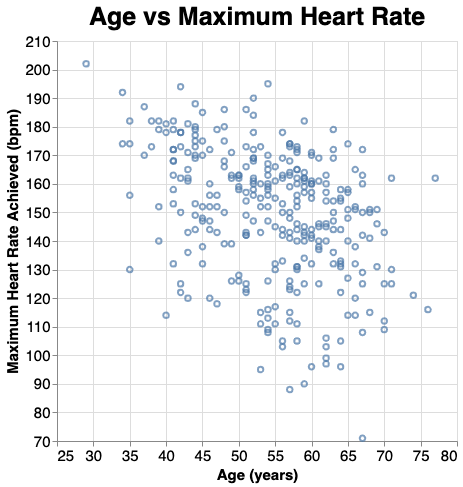

In [9]:
age_vs_thalach = (
    alt.Chart(heart_disease_final, title="Age vs Maximum Heart Rate")
    .mark_point()
    .encode(
        x=alt.X("Age", title="Age (years)",scale=alt.Scale(zero=False)),
        y=alt.Y(
            "Max_Heart_Rate:Q",
            title="Maximum Heart Rate Achieved (bpm)",
            scale=alt.Scale(zero=False)
        ),
    )
    .configure_axis(labelFontSize=15, titleFontSize=15)
    .configure_title(fontSize=25)
    .properties(width=400, height=400)
)
age_vs_thalach

Next, we visualize a bar graph that displays the distribution of diagnosis for each chest pain type:

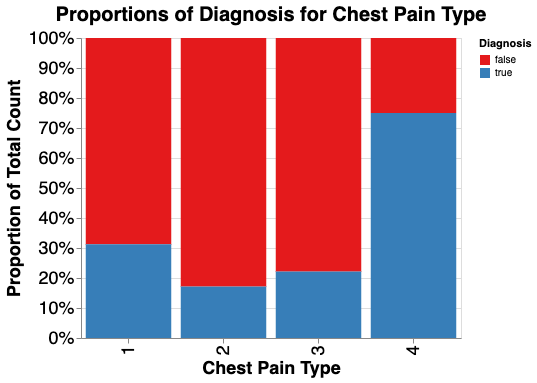

In [10]:
diagnosis_dist_plot = (
    alt.Chart(heart_train, title="Proportions of Diagnosis for Chest Pain Type" )
    .mark_bar()
    .encode(
        y=alt.Y(
            "count(Chest_Pain_Type):Q",
            stack="normalize",
            axis=alt.Axis(format="%"),
            title="Proportion of Total Count",
        ),
        x=alt.X("Chest_Pain_Type:N", title= "Chest Pain Type"),
        fill=alt.Fill(
            "Diagnosis", scale=alt.Scale(scheme="set1")
        ),  # N is to specify this is a categorical variable
    )
    .properties(width=380, height=300)
    .configure_axis(labelFontSize=18, titleFontSize=18)
    .configure_title(fontSize=20)
)
diagnosis_dist_plot

### Data Analysis

From the given dataset, we selected 5 variables as our predictors in order to prevent redundancy or irrelevance. Adding variables that have with weaker correlations leads to overfitting because it would lead to more noise within our model.

The variables we have selected for our model are:
- Age: measured in years
- Chest pain type (cp): 1 = typical angina, 2 = atypical angina, 3 = non-angina pain, 4 = asymptomatic angina
- Serum Cholesterol (chol): measured in mg/dl
- Fasting blood sugar (fbs): measured in mg/dL 
- Maximum heart rate achieved (thalach): measured in beats per min (BPM)

#### Splitting the dataset into training and testing data

In [14]:
# We are using 75% of our data as training data and 25% as testing data

# We will set the stratify argument to the categorical label variable to ensure that the training and testing subsets contain the right proportions of each category of observation.
heart_train, heart_test = train_test_split(
    heart_disease, train_size=0.75, stratify=heart_disease["Diagnosis"] 
)


heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 135 to 107
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       227 non-null    float64
 1   Sex                       227 non-null    float64
 2   Chest_Pain_Type           227 non-null    float64
 3   Resting_Blood_Pressure    227 non-null    float64
 4   Serum_Cholesterol         227 non-null    float64
 5   Fasting_Blood_Sugar       227 non-null    float64
 6   Resting_ECG               227 non-null    float64
 7   Max_Heart_Rate            227 non-null    float64
 8   Exercise_Induced_Angina   227 non-null    float64
 9   ST_Depression_Exercise    227 non-null    float64
 10  Peak_Exercise_ST_Segment  227 non-null    float64
 11  Num_Major_Vessels_Flouro  227 non-null    object 
 12  Thalassemia               227 non-null    object 
 13  Diagnosis                 227 non-null    int64  
dtypes: float

### Methods

The variables we have chosen in order to predict heart disease are as following:
- Age: According to the National Institute of Aging (2018), aging results in significant changes on the heart and blood vessels (arteries), which will directly impact the risks of a heart disease. 

- Chest pain type (cp): As mentioned by Abdullah et al. (2021), chest pain type is a major symptom which has shown to be highly and sensitively correlated to the results of a positive diagnosis for a heart disease, consequently shown to be a predictive factor of heart diseases.

- Serum cholesterol (chol): The state of hypercholesterolemia (high levels of cholesterol) in patients exhibit higher vulnerability towards heart disease, indicating a correlational as well as a causation effect between the two (Mannu et al., 2013).

- Fasting blood sugar (fbs): Those with higher blood sugar levels symptomatic of those with diabetic mellitus suffer from more severe heart diseases, insinuating an association between blood sugar levels and the presence of heart diseases (Saha et al., 2022)

- Maximum heart rate achieved (thalach): As stated by Christine et al. (2009), "an increase in heart rate by 10 beats per minute [is] associated with an increase in the risk of cardiac death by at least 20%". This indicates that the count of heart rate is notable in regards to risk of heart disease.

We will use the K-classification method to run our analysis, by pulling statistical data from the dataset, in order to create a training data and a testing data that will be able to predict if a person has heart disease based on the predictors listed above.

We will visualize the results of the analysis by using a stacked bar chart or a histogram, which shows the distribution of diagnosis for each chest pain type. We will also create scatterplots to show the relationship between different predictor variables.

### Expected outcomes and significance

We expect that individuals who are older, have higher cholesterol levels, present higher maximum heart rate, experience certain chest pain types, and have higher blood sugar levels are more likely to be suffering from heart disease.

These findings will be able to help indicate and predict the possibility of a heart disease and help people improve their health standards in order to prevent developing heart disease.

This analysis could pose questions in the future such as:
- "What habits in our daily life contribute to the development of heart disease in the future?"
- "What methods could be done to prevent factors of heart disease in the future?"
- "What other possible diseases might be indicated by these vital signs?"
- "How do these factors effect the chances of getting a heart disease?"
- "Why do these factors effect the chances of getting a heart disease?"

### References

U.S. Department of Health and Human Services. (2018). Heart health and aging. National Institute on Aging. Retrieved 2023, from https://www.nia.nih.gov/health/heart-health-and-aging 

Sheik Abdullah, A., Selvakumar, S., Venkatesh, M. (2021). Assessment and evaluation of CHD risk factors using weighted ranked correlation and regression with data classification. _Soft Computing, 25_(6), 4979–5001. https://doi.org/10.1007/s00500-021-05663-y 

S. Mannu, G., J.S. Zaman, M., Gupta, A., U. Rehman, H., K. Myint, P. (2013). Evidence of lifestyle modification in the management of Hypercholesterolemia. _Current Cardiology Reviews, 9_(1), 2–14. https://doi.org/10.2174/157340313805076313 

Saha, A., Kuila, M., & Sharma, R. K. . (2022). Relationship of severity of coronary artery disease with fasting blood sugar and glycosylated hemoglobin. _Asian Journal of Medical Sciences, 13_(3), 38–42. https://doi.org/10.3126/ajms.v13i3.40416

Perret-Guillaume, C., Joly, L., &amp; Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. _Progress in Cardiovascular Diseases, 52_(1), 6–10. https://doi.org/10.1016/j.pcad.2009.05.003 